In [57]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

import tqdm as notebook_tqdm

plt.rcParams['font.size'] = 18
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['axes.grid']=False
plt.rcParams['grid.linestyle']='--'
plt.rcParams['grid.linewidth'] = 1.0

sns.set_style("darkgrid")
np.random.seed(42)

colors = ['red', 'green', 'blue', 'magenta', 'cyan']

## データ生成

### スペクトル生成

In [15]:
K = 4
N = 100
D = 50

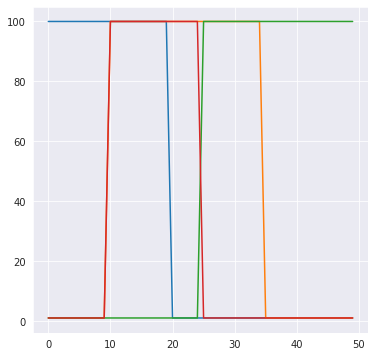

In [20]:
W_t = np.ones([D, K])
W_t[:20, 0] = 100
W_t[10:35, 1] = 100
W_t[25:, 2] = 100
W_t[10:25, 3] = 100
W_t = jnp.array(W_t)

plt.figure(figsize=(6, 6))
for k in range(K):
    plt.plot(W_t[:, k])
plt.show()



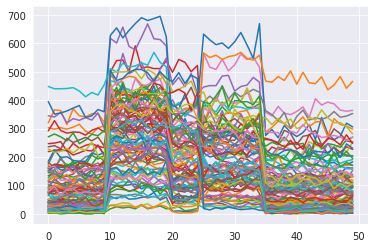

In [21]:
H_t = np.random.gamma(shape=1, scale=1, size=(K, N))
X = np.random.poisson(W_t@H_t)

for n in range(N):
    plt.plot(X[:, n])
plt.show()

### ターゲット変数の生成

In [43]:
w_t = jnp.array([1.0, 1.5, -1.0, -1.5])
f_t = w_t@H_t
y = f_t + np.random.normal(loc=0, scale=0.7, size=N)

### 通常のNMF
複雑な系だと真の構造を捉えることができていない．

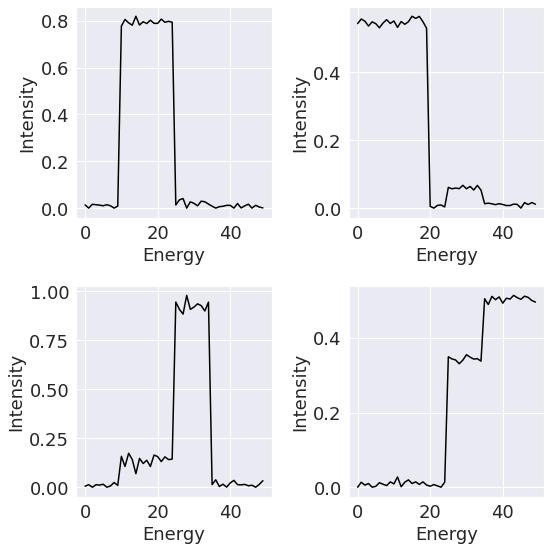

In [110]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=K, init="random", random_state=123, max_iter=1500)
W = nmf.fit_transform( X / np.max(X) )
H = nmf.components_

plt.figure(figsize=(8, 8))
for k in range(K):
    plt.subplot(K//2, K//2, k+1)
    plt.plot(W[:, k], c='k')
    plt.xlabel('Energy')
    plt.ylabel('Intensity')
plt.tight_layout()
plt.show()

## 解析モデル

In [23]:
def model(K, X, y):
    
    ## スペクトル生成
    ## --------------------------------------------------------------------------------
    # D×Kの行列W
    W = numpyro.sample("W", dist.Gamma(concentration=1, rate=0.01).expand([D, K]))
    # K×Nの行列H
    H = numpyro.sample("H", dist.Gamma(concentration=1, rate=1).expand([K, N]))
    
    with numpyro.plate("energy", X.shape[0], dim=-2):
        with numpyro.plate("sample", X.shape[1], dim=-1):
            numpyro.sample("X", dist.Poisson(W@H), obs=X)
 
    ## ターゲット予測
    # --------------------------------------------------------------------------------
    sigma = numpyro.sample("sigma", numpyro.distributions.HalfNormal(1.0))  # observation noise
    
    # w = numpyro.sample("w", numpyro.distributions.Normal(0, 10).expand([H.shape[0]])) 
    beta = numpyro.deterministic("beta", jnp.linalg.lstsq(H.T, y, rcond=None)[0])
    
    # f = numpyro.deterministic("f", w@H)
    
    with numpyro.plate("sample", X.shape[1]):
        numpyro.sample("y", numpyro.distributions.Normal(beta@H, sigma), obs=y)  # observation model
    

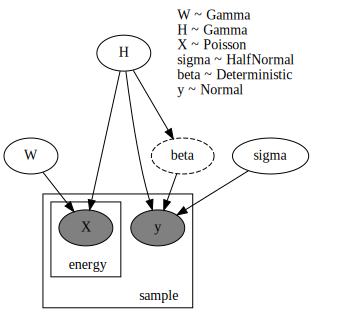

In [24]:
numpyro.render_model(
    model=model, 
    model_kwargs={"K": K, "X": X, "y": y},
    render_params=True, 
    render_distributions=True,
    # filename='prob_model.jpg',
)

### サンプリング

In [75]:
rng_key = jax.random.PRNGKey(42)
num_samples = 5000

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=num_samples,
                            num_samples=num_samples)
mcmc.run(rng_key=rng_key, K=K, X=X, y=y)

samples = mcmc.get_samples()

sample: 100%|██████████| 10000/10000 [01:33<00:00, 107.05it/s, 127 steps of size 4.40e-02. acc. prob=0.86]


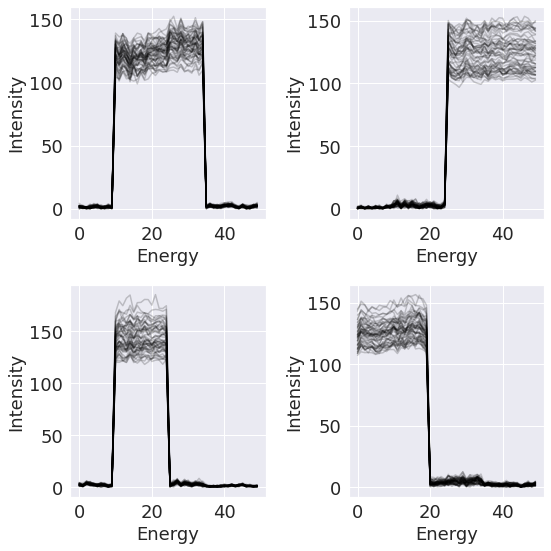

In [82]:
plt.figure(figsize=(8, 8))
for k in range(K):
    plt.subplot(K//2, K//2, k+1)
    c = colors[k]
    for i in range(0, 250, 5):
        plt.plot( samples['W'][-i, :, k], alpha=0.2, color='black')
    plt.xlabel('Energy')
    plt.ylabel('Intensity')
plt.tight_layout()
plt.show()

In [88]:
log_likelihood = numpyro.infer.log_likelihood(model=model, posterior_samples=mcmc.get_samples(), K=K, X=X, y=y)
log_likelihood = -1.0 * ( np.sum(log_likelihood['y'], axis=1) + np.sum(log_likelihood['X'], axis=[1, 2]) )
print( float( jnp.mean( log_likelihood ) ) )

18915.943359375


In [89]:
index = np.argmin(log_likelihood)
print(log_likelihood[index])

eap_beta = samples['beta'][index, :]
eap_H = samples['H'][index, :]

18861.86


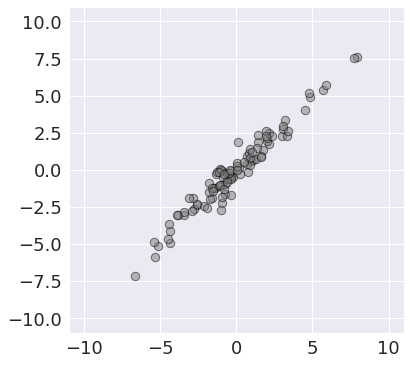

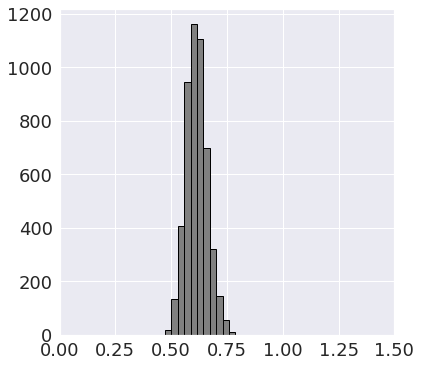

In [101]:
plt.figure(figsize=(6, 6))
y_hat = eap_beta@eap_H
plt.scatter(y, y_hat, c='gray', edgecolor='k', s=70, alpha=0.5)
plt.xlim(-11, 11)
plt.ylim(-11, 11)
plt.show()

plt.figure(figsize=(6, 6))
plt.hist(samples['sigma'], color='gray', edgecolor='k', bins=15)
plt.xlim(0, 1.5)
plt.show()